# Supervised landuse classification with Sentinel2 satellite images

## Introduction
In this execise we will make a landuse classification using satellite images of the bands Blue (02), Green (B03), Red (B04 and Infrared (B08) with a resolution of 10 meter of the [Sentinel-2 satellite](sentinel.esa.int/web/sentinel/missions/sentinel-2). 

If you are not familiar with satellite remote sensing, you can find an introduction [here](https://semiautomaticclassificationmanual-v5.readthedocs.io/de/latest/remote_sensing.html).

We will be using the supervised classification algorithm [Random forest classifier](hhtp://scikit-learn.org/stable/modules/ensemble.html#random-forests). Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. The Random forest implementation is provided by the [scikit-learn](http://scikit-learn.org) library. 

`scikit-learn` is a machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including `numpy`, `scipy`, and `matplotlib`, which makes it very easy to incorporate into your workflow. 

For this notebook you need the following input files:
- Sentinel2 images from the bands 2, 3 ,4 and 8 in TIF format
- Shapefile with at least one sample area for each landuse class

As output the following files are generated:
- classified.tif: Rasterfile with classified landuse map in GeoTIFF format
- classified.shp: Vectorfile with classified landuse map in Shape format


## Importing the Python modules

The first step is to import the modules we are going to use in this exercise:

In [1]:
# Imports Scikit learn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.spatial import ConvexHull
from scipy import interpolate

# Imports gdal and ogr
from osgeo import gdal
from osgeo import gdalconst
from osgeo import ogr
from osgeo import osr
from osgeo import gdalnumeric
from osgeo import gdal_array

# Imports Shapely
from shapely.geometry import shape

# Imports matplotlib and seaborn for visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns

# Import rasterio
import rasterio
from rasterio import features
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import shapes

# Import numpy, pandas and geopandas
import random
import numpy as np
import pandas as pd
import geopandas as gpd

# Import os to access file system
import os
import glob


In [2]:
# Here we define the demo dataset we are going to use
Waalwijk = True
Nepal = False

## Setting the input parameters

After importing the modules, we have to define the locations and the names of the folders and files we are going to use and going to create. In this step you have to define the name of the column of the shapefile that contains the landuse classes (_landuse_column_).


In [3]:
# Dutch dataset from Waalwijk
if Waalwijk :

    # Folder with data files
    data_folder = 'data_files/Waalwijk/' 
    sentinel_folder = data_folder + 'sentinel-2/'

    # Name shapefile with sample areas and name of column with landuse classes
    sample_areas_vector_file = data_folder + '/samples_areas.shp'
    sample_areas_vector_file = data_folder + '/sample_points.geojson'
    landuse_column = 'landuse'

    # Name of new GeoTIFF file with all bands
    sentinel_bands_raster_file = data_folder + 'waalwijk_sentinel_bands.tif'

    # Name of new GeoTIFF file with groud truth sample areas
    sample_areas_raster_file = os.path.splitext(sample_areas_vector_file)[0] + '_waalwijk.tif'

    # Name of new Geotiff file with classified landuse classes
    classified_landuse_raster_file = data_folder + 'waalwijk_classified.tif'
    classified_landuse_vector_file = data_folder + 'waalwijk_classified.shp'

# Nepal dataset from Terai region
if Nepal:
    
    # Folder with data files
    data_folder = 'data_files/Nepal/' 
    sentinel_folder = data_folder + 'sentinel-2/'

    # Name shapefile with sample areas and name of column with landuse classes
    sample_areas_vector_file = data_folder + '/groundtruth_named.shp'
    landuse_column = 'Klasse'

    # Name of new GeoTIFF file with all bands
    sentinel_bands_raster_file = data_folder + 'nepal_sentinel_bands.tif'

    # Name of new GeoTIFF file with groud truth sample areas
    sample_areas_raster_file = os.path.splitext(sample_areas_vector_file)[0] + '_nepal.tif'

    # Name of new Geotiff file with classified landuse classes
    classified_landuse_raster_file = data_folder + 'nepal_classified.tif'
    classified_landuse_vector_file = data_folder + 'nepal_classified.shp'



For more information on the Terai region and the remote sensing data that is used in this notebook, see [here](https://studenttheses.uu.nl/handle/20.500.12932/38655).

Now we make a number of dictionaries and lists to store the landuse classes, their unique ID's and their colors. The relation between landuse class and unique ID is required for conversion from vector format to raster format. The relation between unique ID and landuse class is required for conversion from raster format back to vector format. The colors are used for plotting.



In [4]:
# Import shapefile
gdf_sample_areas = gpd.read_file(sample_areas_vector_file)

# Get a list of unique landuse classes
landuse_classes_list = gdf_sample_areas[landuse_column].unique().tolist()

# Write landuse classes to dictionary with a unique number for rasterizing
landuse_class_id_dict = {}
id_landuse_class_dict = {}
i = 1
for landuse_class in landuse_classes_list:
    landuse_class_id_dict[landuse_class] = i
    i = i + 1

# Invert dictionary for vectorizing
id_landuse_class_dict = {landuse_class_id_dict[k] : k for k in landuse_class_id_dict}

# Write random colors to dictionary for later plotting
landuse_class_color_dict = {}
if Waalwijk: 
    landuse_class_color_dict['water'] = '#0080ff'
    landuse_class_color_dict['forest'] = '#327f10'
    landuse_class_color_dict['sand'] = '#fcbe03' 
    landuse_class_color_dict['grass'] = '#8fce00'
    landuse_class_color_dict['buildings'] = '#cc0000'
    landuse_class_color_dict['cropland'] = '#ffe599' 
    landuse_class_color_dict['shrubs'] = '#808000'
if Nepal:
    landuse_class_color_dict['Water'] = '#0080ff'
    landuse_class_color_dict['Forest'] = '#327f10'
    landuse_class_color_dict['Bare'] = '#e0b62b' 
    landuse_class_color_dict['Grassland'] = '#8fce00'
print("Landuse classes and colors: " + str(landuse_class_color_dict))

# For random colors
""" for row in gdf_sample_areas[[landuse_column]].iterrows():
    landuse_class = row[1][0]
    landuse_color = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])][0]
    landuse_class_color_dict[landuse_class] = landuse_color """

# Write colors to list for later plotting
landuse_class_color_list = []
for landuse_class in landuse_classes_list :
    landuse_class_color_list.append(landuse_class_color_dict[landuse_class]) 


Landuse classes and colors: {'water': '#0080ff', 'forest': '#327f10', 'sand': '#fcbe03', 'grass': '#8fce00', 'buildings': '#cc0000', 'cropland': '#ffe599', 'shrubs': '#808000'}


## Preparing the satellite images

Now we need to collect all the Sentinel-2 bands because they come as individual images one per band. We merge them into one GeoTIFF image with multiple bands and then we plot the individual bands and the a false color composite for a visual inspection.

In [5]:
# Find every file in the sentinal directory
sentinal_band_paths_array = [os.path.join(sentinel_folder, f) for f in os.listdir(sentinel_folder) if os.path.isfile(os.path.join(sentinel_folder, f))]
sentinal_band_paths_array.sort()

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths_array[0]) as sentinal_band_path_handle:
    meta = sentinal_band_path_handle.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths_array))

# Read each layer and write it to stack
with rasterio.open(sentinel_bands_raster_file, 'w', **meta) as sentinel_bands_handle:
    for id, layer in enumerate(sentinal_band_paths_array, start=1):
        with rasterio.open(layer) as layer_handle:
            sentinel_bands_handle.write_band(id, layer_handle.read(1))

# Close files
sentinal_band_path_handle = None
sentinel_bands_handle = None

We can plot the individual bands of the rasterfile

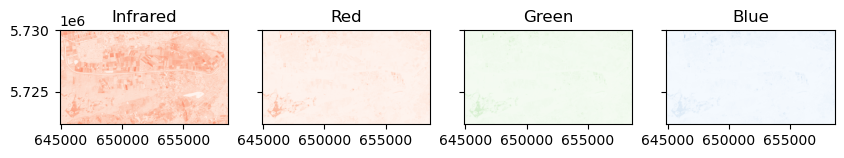

In [6]:
# Open file
sentinel_bands_raster_handle = rasterio.open(sentinel_bands_raster_file)

# Initialize subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((sentinel_bands_raster_handle, 4), cmap='Reds', ax=ax1)
show((sentinel_bands_raster_handle, 3), cmap='Reds', ax=ax2)
show((sentinel_bands_raster_handle, 2), cmap='Greens', ax=ax3)
show((sentinel_bands_raster_handle, 1), cmap='Blues', ax=ax4)

# Add titles
ax1.set_title("Infrared")
ax2.set_title("Red")
ax3.set_title("Green")
ax4.set_title("Blue")

# Close file
sentinel_bands_raster_handle = None

We can also combine bands to make false color composites to highlight for example the vegetation (red in a false color composite)

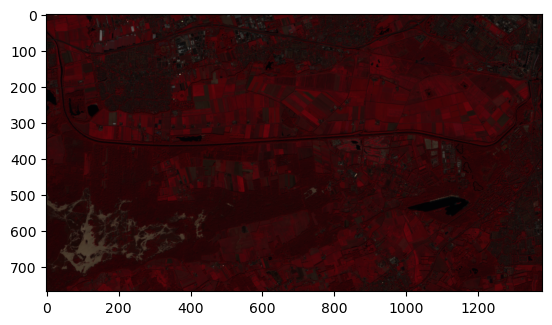

In [7]:
# Function to normalize bands into 0.0 - 1.0 scale
def normalize(array_in):
    array_min, array_max = array_in.min(), array_in.max()
    return (array_in - array_min) / (array_max - array_min)

# Plot the file with the bands
sentinel_bands_raster_handle = rasterio.open(sentinel_bands_raster_file)

# read 3 bands used for visualisation and convert to numpy arrays
nir_array = sentinel_bands_raster_handle.read(4)
red_array = sentinel_bands_raster_handle.read(3)
green_array = sentinel_bands_raster_handle.read(2)

# Close raster
sentinel_bands_raster_handle = None

# Normalize band DN
nir_norm_array = normalize(nir_array)
red_norm_array = normalize(red_array)
green_norm_array = normalize(green_array)

# Stack bands
nrg_array = np.dstack((nir_norm_array, red_norm_array, green_norm_array))

# View the color composite
plt.imshow(nrg_array)

## Rasterizing the landuse sample areas

Now we need to rasterize the vector file with the sample areas (ground truth) we are going to use for training ang testing the model. The first step is to get the coördinatie system of the satellite image and transform the sample areas to the same coordinate system.

In [8]:
# Get the coordinate system of the satellite image
sentinel_bands_handle = rasterio.open(sentinel_bands_raster_file) 
print('Coordinate system of the satellite image: ' + str(sentinel_bands_handle.crs))
project_crs = sentinel_bands_handle.crs
sentinel_bands_handle.close()

# Read sample polygons and replace landuse description with landuse id for rasterizing and perform coordinate transformation
gdf_sample_areas_tmp = gpd.read_file(sample_areas_vector_file)
gdf_sample_areas = gdf_sample_areas_tmp.replace({landuse_column: landuse_class_id_dict}).to_crs(project_crs)


Coordinate system of the satellite image: EPSG:32631


The next step is the rasterization. We use the unique value of each landuse class to burn into the raster image.

In [9]:
# Open rasterfile and get metadata
raster_file = glob.glob(sentinel_folder + '*.tif')[0]
raster_file_handle = rasterio.open(raster_file)
meta = raster_file_handle.meta.copy()
meta.update(compress='lzw')

# Close the rasterfile
raster_file_handle = None

# Rasterize the vectorfile
with rasterio.open(sample_areas_raster_file, 'w+', **meta) as out:
    out_arr = out.read(1)

    # Read the shapes from the vector file and burn the unique value for the landuse class into the raster file
    shapes = ((geom,value) for geom, value in zip(gdf_sample_areas.geometry, gdf_sample_areas[landuse_column]))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    print(out)
    out.write_band(1, burned)

# The rasterized file
print('The raster file sample areas: ' + str(sample_areas_raster_file))

<open DatasetWriter name='data_files/Waalwijk//sample_points_waalwijk.tif' mode='w+'>
The raster file sample areas: data_files/Waalwijk//sample_points_waalwijk.tif


For a visual ispection we are going to plot the generated raster file with the sample areas.

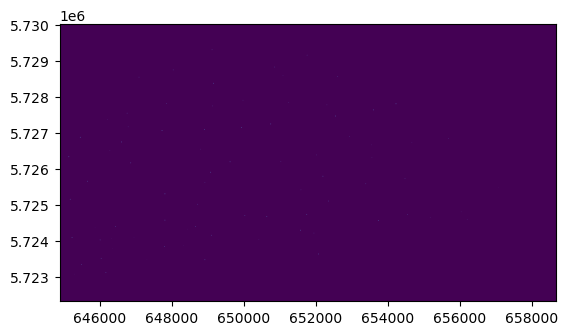

In [10]:
# Open the file:
sample_areas_raster_handle = rasterio.open(sample_areas_raster_file)

# Plot band 1
show((sample_areas_raster_handle, 1))

# CLose file
sample_areas_raster_handle = None

## Determining the spectral reflectance curve

The following step is to determine the spectral reflectance curve for each landuse class. Therefore we have to split the dataset into an array with features (the different bands) and an array with the labels (the landuse classes to predict). The spectral reflectance curve or spectral signature is the reflectance as a function of wavelength (often represented by the satellite band) ann is used for the landuse classification.

In [11]:
# Display rows, columns and number of bands
sentinel_bands_handle = gdal.Open(sentinel_bands_raster_file)
nr_of_cols  = sentinel_bands_handle.RasterXSize
nr_of_rows  = sentinel_bands_handle.RasterYSize
nr_of_bands = sentinel_bands_handle.RasterCount

# Store bands from satellite image in array   
sentinel_bands_array = np.zeros((nr_of_rows, nr_of_cols, nr_of_bands), gdal_array.GDALTypeCodeToNumericTypeCode(gdal.GDT_Int16))
for band_nr in range(nr_of_bands):
    sentinel_bands_array[:, :, band_nr] = sentinel_bands_handle.GetRasterBand(band_nr + 1).ReadAsArray()

# Find how many non-zero entries we have -- i.e. how many training data samples?
sample_areas_handle = gdal.Open(sample_areas_raster_file, gdal.GA_ReadOnly)
sample_areas_array = sample_areas_handle.GetRasterBand(1).ReadAsArray().astype(np.uint16)
n_samples = np.sum(sample_areas_array[(sample_areas_array > 0)])
print('We have ' + str(n_samples) + ' samples')

# What are our classification labels?
labels = np.unique(sample_areas_array[(sample_areas_array > 0)])
print('The training data include ' + str(labels.size) + ' classes: ' + str(labels))

# Make an array with the features (bands) and the labels to predict
X = sentinel_bands_array[(sample_areas_array > 0), :]  
y = sample_areas_array[(sample_areas_array > 0)]

# Close file
sentinel_bands_handle = None

We have 336 samples
The training data include 7 classes: [1 2 3 4 5 6 7]


Now that we have a list with the features (the 4 bands) and a list with labels (landuse classes) we can plot the spectral reflectance curve.

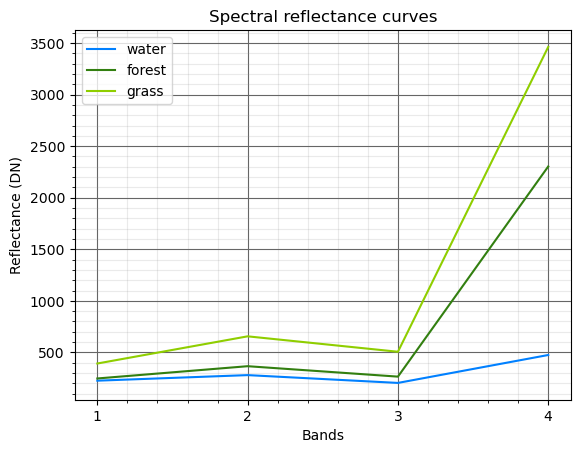

In [12]:
# Make array with number of bands
band_count = np.arange(1,nr_of_bands + 1)
band_sentinel = ['B02', 'B03' , 'B04', 'B08']

# Calculate mean reflectance for each band in each class
classes = np.unique(y)
for class_type in classes:
    if class_type in (2,6,7)  :
        band_intensity = np.mean(X[y==class_type, :], axis=0)
        label = id_landuse_class_dict[class_type]
        plt.plot(band_count, band_intensity, label=label, color=landuse_class_color_dict[label])

# Annotation figure
plt.title('Spectral reflectance curves')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc=0)
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Bands')
plt.ylabel('Reflectance (DN)')
plt.show()

The next step is to plot the landuse classes as a function of the different bands. In this example we use the bands Blue (B02) on the x-axis and Infrared (B08) on the y-axis.

C:\Users\TeM\AppData\Local\Temp\ipykernel_18484\2844315095.py:34: MatplotlibDeprecationWarning:

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.

C:\Users\TeM\AppData\Local\Temp\ipykernel_18484\2844315095.py:36: MatplotlibDeprecationWarning:

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.

C:\Users\TeM\AppData\Local\Temp\ipykernel_18484\2844315095.py:91: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\TeM\AppData\Local\Temp\ipykernel_18484\2844315095.py:91: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\TeM\AppData\Local\Temp\ipykernel_18484\2844315095.py:91: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.

C:\Users\TeM\AppData\Local\

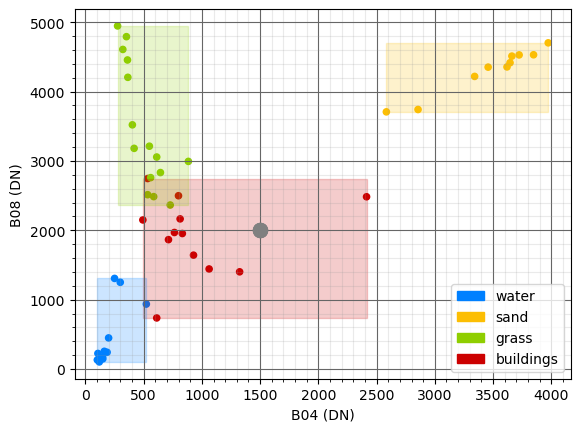

In [16]:
# Get bands
band_x_axis = X[:,2]
band_y_axis = X[:,3]

# Make list with landuse classes and colors to be used in plot
landuse_classes_names_array = []
for landuse_class in sample_areas_array[(sample_areas_array > 0)]:
   landuse_classes_names_array.append(id_landuse_class_dict[landuse_class])
   
# Make a Pandas dataframe
df = pd.DataFrame({'x':band_x_axis, 'y':band_y_axis, 'landuse':landuse_classes_names_array})

# Plot (marginal_x='box', marginal_y='box',)
fig = px.scatter(df, x="x", y="y", color='landuse',  category_orders={"landuse": landuse_classes_list}, color_discrete_sequence=landuse_class_color_list, labels = {"x" : "B04 (DN)", "y" : "B08 (DN)", })
fig.show()

# Plot voor Waalwijk
if Waalwijk:

   # Select subset
   df = df[df['landuse'].isin(['water','buildings','sand','grass'])]
   df.plot(kind='scatter',x='x',y='y',c=df['landuse'].map(landuse_class_color_dict), xlabel='B04 (DN)', ylabel='B08 (DN)', grid=True)
   
      # Create legend
   legend_entries = []
   colors = []
   for key, value in landuse_class_color_dict.items(): 
      if key in ['water','buildings','sand','grass']:
         legend_entries.append(mpatches.Patch(color=value, label=key))
         colors.append(value)
   plt.legend(handles=legend_entries, loc='lower right')

   # Gridline
   plt.grid(b=True, which='major', color='#666666', linestyle='-')
   plt.minorticks_on()
   plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

   # hull or not
   # 1 = Parallepided
   # 2 = Minimum distance
   CLASSIFIER = 1
   unknown_point_x = 1500
   unknown_point_y = 2000
   HULL = False
      
   # Draw enclosure
   df_new = df[['x','y','landuse']]
   df_new['cluster'] = df_new['landuse'].map(landuse_class_id_dict)  
   for i in df_new.cluster.unique():

      df_points = df_new[df_new.cluster == i][['x', 'y']]
      points_array = df_points.values.tolist()
      points = np.array(points_array)
      x_c = points[:,0]
      y_c = points[:,1]
      x_min = np.min(x_c)
      x_max = np.max(x_c)
      y_min = np.min(y_c)
      y_max = np.max(y_c)
      x_ctr = (x_min + x_max)/2
      y_ctr = (y_min + y_max)/2

      # Kernel density
      # Calculate the point density
      #from scipy.stats import gaussian_kde
      #xy = np.vstack([x_c,y_c])
      #z = gaussian_kde(xy)(xy)
      #plt.scatter(x_c, y_c, c=z, s=100)
            
      # Get convex hull
      if CLASSIFIER == 1:
         if HULL:
            hull = ConvexHull(points)
            
            # Get x and y coordinates and repeat last point to close the polygon
            x_hull = np.append(points[hull.vertices,0],
                              points[hull.vertices,0][0])
            y_hull = np.append(points[hull.vertices,1],
                              points[hull.vertices,1][0])

            # Interpolate
            dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
            dist_along = np.concatenate(([0], dist.cumsum()))
            spline, u = interpolate.splprep([x_hull, y_hull], 
                                             u=dist_along, s=0, per=1)
            interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
            interp_x, interp_y = interpolate.splev(interp_d, spline)
            plt.fill(interp_x, interp_y, '--', c=landuse_class_color_dict[id_landuse_class_dict[i]], alpha=0.2)
         else:
            # Plot MBR
            rect=mpatches.Rectangle((x_min,y_min),(x_max-x_min),(y_max-y_min), 
                           fill = True,
                           color = landuse_class_color_dict[id_landuse_class_dict[i]],
                           facecolor = landuse_class_color_dict[id_landuse_class_dict[i]],
                           linewidth = 1, alpha=0.2)
            plt.gca().add_patch(rect)
            plt.plot([unknown_point_x], [unknown_point_y], marker='o', ls='none', c='grey', ms=10)
      
      # Plot minimum distance
      if CLASSIFIER == 2:
         color = landuse_class_color_dict[id_landuse_class_dict[i]]
         marker = ('D')
         size = 100
         plt.plot([x_ctr], [y_ctr], marker='D', ls='none', c=color, ms=10)
         plt.plot([x_ctr, unknown_point_x], [y_ctr, unknown_point_y], c=color)
         plt.plot([unknown_point_x], [unknown_point_y], marker='o', ls='none', c='grey', ms=10)





## Training and testing the model 

Now that we the array with the features (bands) and an array with the labels (landuse classes to predict) we can build our random forest classifier.

First we split the arrays into a training set to train the model and a test set to test the model. 70% of the points is used for training and 30% for testing. Then we train the model using the training set and after that we test the model with the test set to get its accuracy.

Accuracy: 0.7142857142857143
Our OOB prediction of accuracy is: 54.166666666666664%


Text(19.25, 0.5, 'Actual')

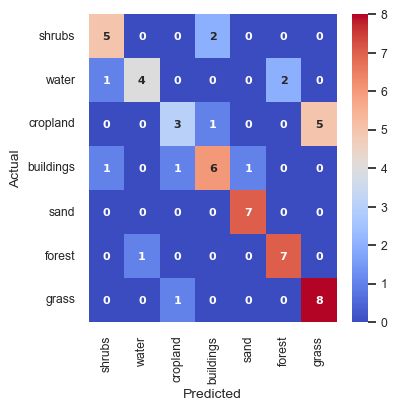

In [14]:
# Split the dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7) # 70% training and 30% test

# Initialize our model with 50 trees
rf_model = RandomForestClassifier(n_estimators=50, oob_score=True)

# Train the model using the training sets 
rf_model.fit(X_train,y_train)

# Use the model to predict
y_pred = rf_model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy: " +str(metrics.accuracy_score(y_test, y_pred)))

# Print prediction
print('Our OOB prediction of accuracy is: ' + str(rf_model.oob_score_ * 100) + '%')

# Confusion matrix to see how many points are correctly classified
conf_mat = metrics.confusion_matrix(y_test, y_pred)
#categories = landuse_classes_list
df_conf_matrix = pd.DataFrame(conf_mat,columns=landuse_classes_list,index=landuse_classes_list)

# Plot confusion matrix heatmap
plt.figure(figsize=(4, 4))
sns.set(font_scale=0.8)
sns.heatmap(df_conf_matrix,
            cmap='coolwarm',
            annot=True,
            fmt='.5g',
            annot_kws={
                'fontsize': 8,
                'fontweight': 'bold',
                'fontfamily': 'DejaVu Sans'
            })
plt.xlabel('Predicted',fontsize=10)
plt.ylabel('Actual',fontsize=10)


## Using the model for landuse classification

Using the generated model, we are going to classify all the pixels in our image using the 4 different bands into a landuse clas. The output is a classified raster image of the study area.

In [18]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (nr_of_cols * nr_of_rows, nr_of_bands)
sentinel_bands_array_reshaped = sentinel_bands_array[:, :, :].reshape(new_shape)
print('Reshaped from ' + str(sentinel_bands_array.shape) + ' to ' + str(sentinel_bands_array_reshaped.shape))

# Now predict for each pixel using the generated model 
class_prediction = rf_model.predict(sentinel_bands_array_reshaped)

# Reshape our classification map back to the original number of rows and columns
class_prediction = class_prediction.reshape(sentinel_bands_array[:, :, 0].shape)

# Open raster and get the number of rows, columns and coordinate system for raster file
raster_file_handle = gdal.Open(sample_areas_raster_file, gdalconst.GA_ReadOnly )
nr_of_columns = raster_file_handle.RasterXSize
nr_of_rows = raster_file_handle.RasterYSize
crs_wkt = raster_file_handle.GetProjection() 

# Make empty GeoTIFF raster file
driver = gdal.GetDriverByName("GTiff")
if os.path.isfile(classified_landuse_raster_file) :
    os.remove(classified_landuse_raster_file)
raster_file_classified_handle = driver.Create(classified_landuse_raster_file, nr_of_columns, nr_of_rows, 1, gdal.GDT_Int16)

# Copy dataset info (rastersize and pixelsize)
gdalnumeric.CopyDatasetInfo(raster_file_handle, raster_file_classified_handle)

# Get empty array from file and write landuse classes to rasterfile 
rasterband_out_array = raster_file_classified_handle.GetRasterBand(1)
gdalnumeric.BandWriteArray(rasterband_out_array, class_prediction)

# Close file
raster_file_classified_handle = None

# Print name of generated file
print("Raster file " + classified_landuse_raster_file + " generated")

Reshaped from (769, 1378, 4) to (1059682, 4)
Raster file data_files/Waalwijk/classified.tif generated


For visual inspection, we are going to visualize the classified landuse map

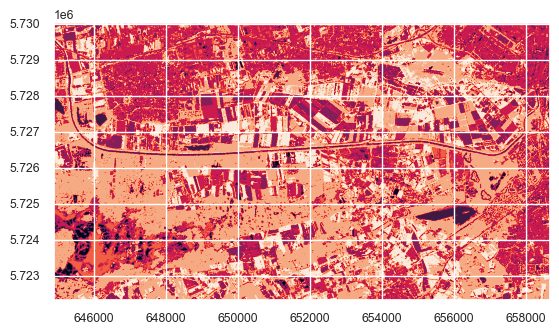

{1: 'shrubs', 2: 'water', 3: 'cropland', 4: 'buildings', 5: 'sand', 6: 'forest', 7: 'grass'}


In [19]:
# Open the file:
classified_landuse_handle = rasterio.open(classified_landuse_raster_file)

# Plot band 1
show(classified_landuse_handle, 1)

# Print the legend
print(id_landuse_class_dict)

# Close raster
classified_landuse_handle = None

## Vectorizing the generated landuse map

Because the generated raster landuse map does only contain the unique numbers of each landuse class and not the landuse class names, the generated rasterfile is converted into a vectorfile (shapefile) with landuse classes.

In [18]:
# Open te rasterfile, vectorize and keep generated geometries
import rasterio
from rasterio.features import shapes
mask = None
with rasterio.Env():
    with rasterio.open(classified_landuse_raster_file) as classified_landuse_handle:
        classified_landuse_array = classified_landuse_handle.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(classified_landuse_array, mask=mask, transform=classified_landuse_handle.transform)))

# Close file
classified_landuse_handle = None

# List of generated geometries
geoms = list(results)

# Get coordinate system 
dest_crs = osr.SpatialReference()
dest_crs.ImportFromEPSG(int(project_crs.to_string().split(':')[1]))

# Defining and opening output vectorfile
vector_driver = ogr.GetDriverByName('Esri Shapefile')
vector_handle = vector_driver.CreateDataSource(classified_landuse_vector_file)
layer = vector_handle.CreateLayer('', dest_crs, ogr.wkbPolygon)

# Definition of attributes of output vectorfile
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
layer.CreateField(ogr.FieldDefn(landuse_column, ogr.OFTString))
defn = layer.GetLayerDefn()

## Create feature and write to output vectorfile
for geom in geoms:
    
    # Create a new feature (attribute and geometry)
    feat = ogr.Feature(defn)
    feat.SetField('id', int(geoms[0]['properties']['raster_val']))
    feat.SetField(landuse_column, id_landuse_class_dict[int(geom['properties']['raster_val'])])

    # Make a geometry, from Shapely object
    poly = shape(geom['geometry'])
    geom = ogr.CreateGeometryFromWkb(poly.wkb)
    feat.SetGeometry(geom)

    # Add feature to layer
    layer.CreateFeature(feat)
    feat = geom = None  # destroy these

# Save and close everything
vector_handle = layer = feat = geom = None

# Print name of generated file
print("Vector file " + classified_landuse_vector_file + " generated")


Vector file data_files/Waalwijk/classified.shp generated


As a last step, we are plotting the resulting vectorfile

<AxesSubplot:>

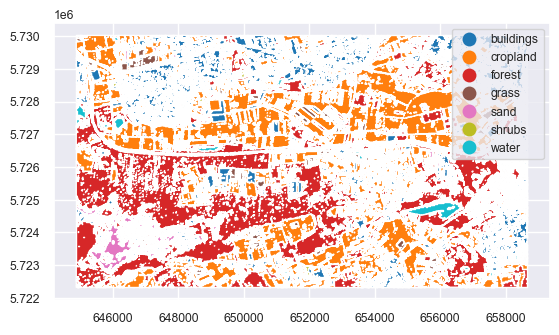

In [19]:
import matplotlib.pyplot as plt

# Import vectorfile in geopandas dataframe
gdf_classified_landuse = gpd.read_file(classified_landuse_vector_file)

# Set plot area
fig, ax = plt.subplots(1, 1)

# Plot the landuse classes
gdf_classified_landuse.plot(column=landuse_column,
           ax=ax,
           legend=True)